# Marketing campaign 

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import os, json

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import warnings
warnings.filterwarnings('ignore')

from sklearn import tree, ensemble, metrics, preprocessing 
from sklearn.preprocessing  import LabelEncoder, MinMaxScaler
from sklearn import linear_model 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import IsolationForest, StackingClassifier
from sklearn.metrics import roc_curve
import optuna
import pickle

#from collections import OrderedDict
random_seed=42

## 1. Problem definition

A bank initiated the marketing campaign among its clients to deposit money. After it was finished, the management decided to identfy success factors of the campaign using machine learning algorythm to increase its efficiency and decrease costs.

## 2. EDA

### Bank client data:

* **Age** (numeric)
* **Job** : type of job (categorical: 'admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management', 'retired', 'self-employed', 'services', 'student', 'technician', 'unemployed', 'unknown')
* **Marital** : marital status (categorical: 'divorced', 'married', 'single', 'unknown' ; note: 'divorced' means divorced or widowed)
* **Education** (categorical: 'primary', 'secondary', 'tertiary', 'unknown')
* **Default**: has credit in default? (categorical: 'no', 'yes', 'unknown')
* **Housing**: has housing loan? (categorical: 'no', 'yes', 'unknown')
* **Loan**: has personal loan? (categorical: 'no', 'yes', 'unknown')

### Related with the last contact of the current campaign:

* **Contact**: contact communication type (categorical:
'cellular','telephone')
* **Month**: last contact month of year (categorical: 'jan', 'feb', 'mar', …, 'nov', 'dec')
* **Day**: last contact day of the week (numerical)
* **Duration**: last contact duration, in seconds (numeric). Important
note: this attribute highly affects the output target (e.g., if
duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known.
Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic
predictive model.


### Other attributes:

* **Campaign**: number of contacts performed during this campaign and for this client (numeric, includes last contact)
* **Pdays**: number of days that passed by after the client was last
contacted from a previous campaign (numeric; -1 means client was not previously contacted)
* **Previous**: number of contacts performed before this campaign and for this client (numeric)
* **Poutcome**: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
Social and economic context attributes.

### Target value:

* **deposit** : has the client subscribed a term deposit? (binary: 'yes', 'no')

In [2]:
df = pd.read_csv('../data/campaign.zip', sep = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


## missing entries

In [3]:
cols_null_percent = df.isna().mean()*100
cols_null = cols_null_percent[cols_null_percent > 0].sort_values(ascending=False)
display(cols_null)

balance    0.223974
dtype: float64

In [4]:
df['balance'].isna().value_counts()

False    11137
True        25
Name: balance, dtype: int64

Luckily only 'balance' feature contains 25 missing data entries. 

### Job

In [5]:
df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

It is likely missed values are marked as 'unknown' though they aren't empty. Thus there is no reason to delete them. 

In [6]:
# Cleaning 'job' feature
df['job'] = df['job'].apply(lambda x:  df['job'].mode()[0] if x=='unknown' else x)
df['job'].mode()[0]

'management'

### Education

In [7]:
df['education'].value_counts()

secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: education, dtype: int64

In [8]:
# Cleaning 'education' feature
df['education'] = df['education'].apply(lambda x:  df['education'].mode()[0] if x=='unknown' else x)
df['education'].mode()[0]

'secondary'

### Balance

In [9]:
df['balance'].head()

0     2 343,00 $ 
1        45,00 $ 
2     1 270,00 $ 
3     2 476,00 $ 
4       184,00 $ 
Name: balance, dtype: object

We can see that entries ends with a dollar symbol and commas like ',00 $'. The feature's type is 'object'. Special symbols and spaces must be removed; commas should be replaced to dots. At last, we will change column type to numerical.

In [10]:
df['balance'] = df['balance'].apply(lambda x: str(x).replace(' ', '')\
    .replace('$', '').replace(',', '.')).astype('float')
    
#print(df['balance'].mean().round(3))
print('Feature type: ', df['balance'].dtype)
print(df['balance'].isna().value_counts())

Feature type:  float64
False    11137
True        25
Name: balance, dtype: int64


In [11]:
# fill empty values with median
df['balance'] = df['balance'].fillna(df['balance'].median())
print(df['balance'].isna().value_counts())
print('Mean balance: {} $'.format(df['balance'].mean().round(3)))

False    11162
Name: balance, dtype: int64
Mean balance: 1526.936 $


In [12]:
fig = px.box(
    data_frame=df, 
    x='balance'
)

fig.update_layout(
    title=dict(text="Fig.1 - Customers' balances distribution", x=.5, y=0.01, xanchor='center'),
    xaxis_title_text = 'Balance, $',
    width=800, height=200,
    margin=dict(l=100, r=60, t=80, b=70),
)
#fig.show()
fig.write_image('../figures/fig_1.png')

<center> <img src="../figures/fig_1.png"></center>

Let us delete outliers using Tukey method

In [13]:
def outliers_tukey(data:pd.DataFrame, feature:str, log_scale=False):
    """
    Identification of outliers by J.Tukey method
    - DataFrame;
    - feature to process
    - log_scale. If True, the data will be in the log scale else not.
    """
    if log_scale:
        x = np.log(data[feature])
    else:
        x = data[feature]
        
    IQR = data[feature].quantile(.75) - df['balance'].quantile(.25)
  
    lower_bound = data[feature].quantile(.25) - 1.5*IQR
    upper_bound = data[feature].quantile(.75) + 1.5*IQR 
    
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    print('Boundaries: ',lower_bound.round(), upper_bound.round())
    return outliers, cleaned

outliers, data = outliers_tukey(df, 'balance')
print(f'Number of outliers: {outliers.shape[0]}')

data.head()

Boundaries:  -2241.0 4063.0
Number of outliers: 1057


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes


## EDA

### Target value classes balance

no     5423
yes    4681
Name: deposit, dtype: int64


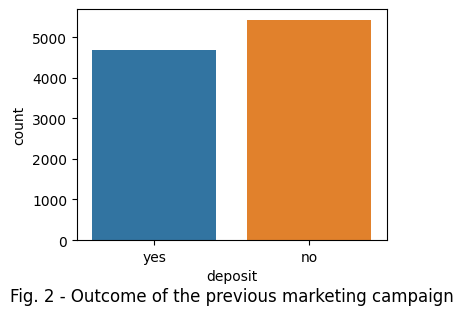

In [14]:
fig, ax = plt.subplots(figsize=(4, 3)) 
sns.countplot(data=data, x='deposit')
ax.set_title('Fig. 2 - Outcome of the previous marketing campaign', y=-0.3);

plt.savefig('../figures/fig_2.png')

print(data['deposit'].value_counts())

Classes of the target value are almost balanced.

### Numeric features

In [15]:
# selection of numerical features
num_features = [s for s in data.columns if data[s].dtypes != 'object']
data[num_features].describe().T

,count,mean,std,min,25%,50%,75%,max
age,10104.0,40.895487,11.735511,18.0,32.0,38.0,48.00,95.0
balance,10104.0,807.331354,993.673452,-2049.0,95.0,444.5,1224.75,4062.0
day,10104.0,15.590657,8.441852,1.0,8.0,15.0,22.00,31.0
duration,10104.0,368.777712,346.650712,2.0,137.0,252.0,490.00,3881.0
campaign,10104.0,2.516924,2.707180,1.0,1.0,2.0,3.00,43.0
pdays,10104.0,51.307700,109.643031,-1.0,-1.0,-1.0,2.00,854.0
previous,10104.0,0.816112,2.243875,0.0,0.0,0.0,1.00,58.0


#### Feature study:

* **age** - Maximal client age is 95 years, that is rather an outlier. Data shape is log-normal with positive skew. It indicates that most of clients are aged: $40.8 \pm 11.7$ years. Age is not interrelated with the target variable - deposit.
* **balance** - Feature is log-normally distributed. Notably, sums on clients' coounts are relatively small: [-2049; 4062] $ with a peak around $0. Most clients have positive balance. The feature has a weak direct relationship with the target.
* **day** - Feature is not normally disributed. Low client activity is observerd at 11 and 24th day after the contact, тогда как высокая - в районе 6, 20 и 30 дней.  
* **duration** - распределение лог-нормальное с сильной положительной ассимметрией. В среднем контакт с клиентами длился $6 \pm 6$ мин (или $369 \pm 365$ сек.). Медианное время контакта довольно непродолжительное и составляет 4,2 мин (или 252 сек). Минимальная и максимальная длительности разговора - 2 и 3881 сек(1 час 4 мин) соответственно. Крайние значения, скорее всего, являются выбросами. Признак слабо коррелирует с целевым (коэффициент корреляции 0,45).
* **campaign** - количество контактов с клиентом во время текущей компании есть дискретная случайная величина, которая распределена не нормально. С каждым клиентом контактировали минимум 1 раз, а в среднем $2.5 \pm 2.7$ раз. Максимум контактов с кодним клиентом - 43 раза, что похоже на выброс. Количество контактов очень слабо отрицательно коррелирует с целевой переменной. Это можно интерпретировать так, что часть клиентов отказалась от депозита после контакта с сотрудниками, проводившими маркетинговую компанию.
* **pdays** - кол-во пропущенных количество дней от последней маркетинговой компании до контакта имеет неравномерное прямоугольное распределение. Признак распределен ненормально: имеет положительную ассимметрию и множество выбросов. Данные совокупности находятся  в диапазоне [-1; 854]. Предположим, что под отрицательными значениями понимается отсутстви контактов с клиентом. Если их не учитывать, то медианное время составляет $182 \pm 123$ дня. Признак очень слабо положительно коррелирует с целевой переменной,- открытие депозита. Это может означать, что контакт с клиентом положительно влияет на открытие депозита.
* **previous** - количество контактов с клиентом до текущей компании. С подавляющим большинством клиентов совокупности контактов не было. Признак имеет лог-нормальное распределение и содержит множество выбросов. Если не учитывать клиентов, с которыми контактировали впервые, то медианное количество контактов равно 2. Признак очень слабо положительно коррелирует с целевой переменной.

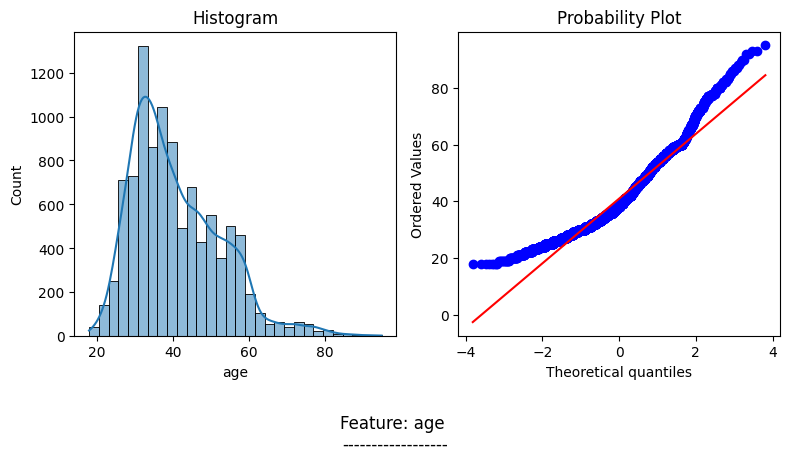

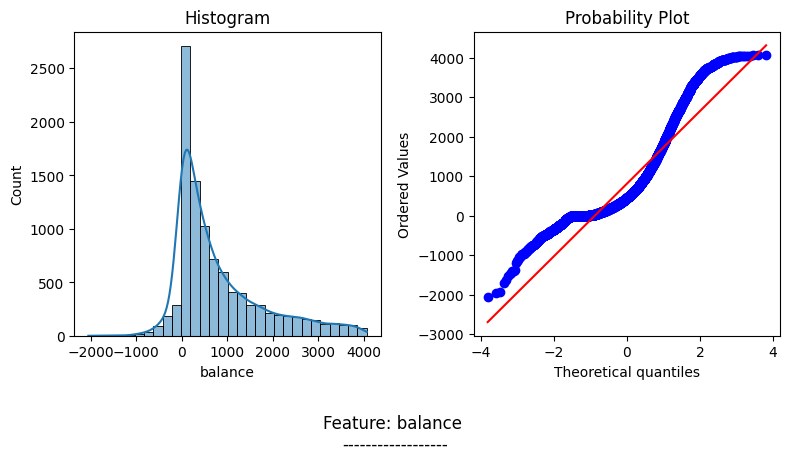

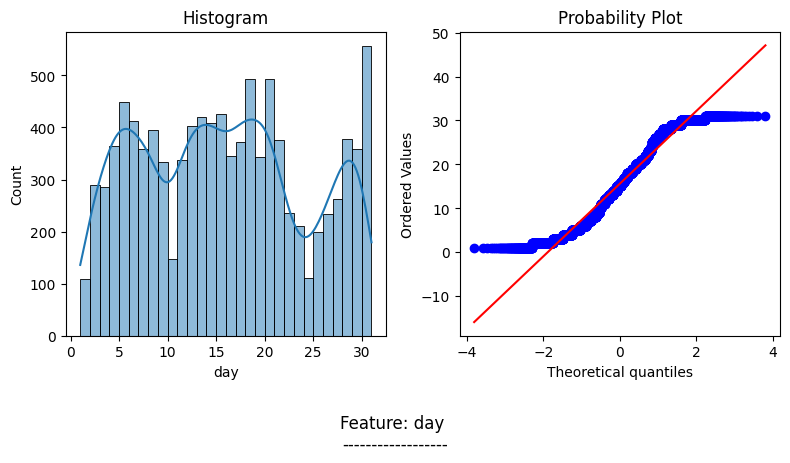

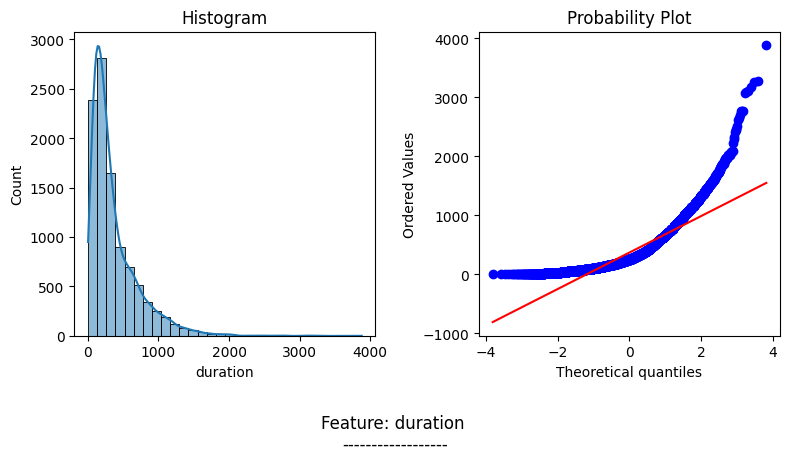

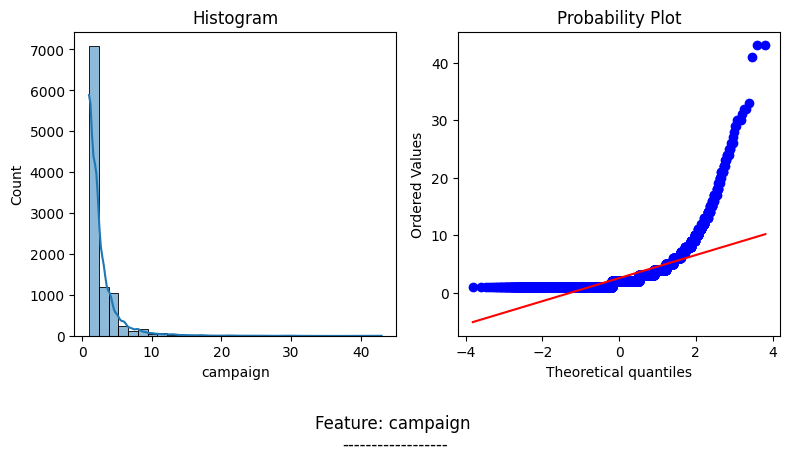

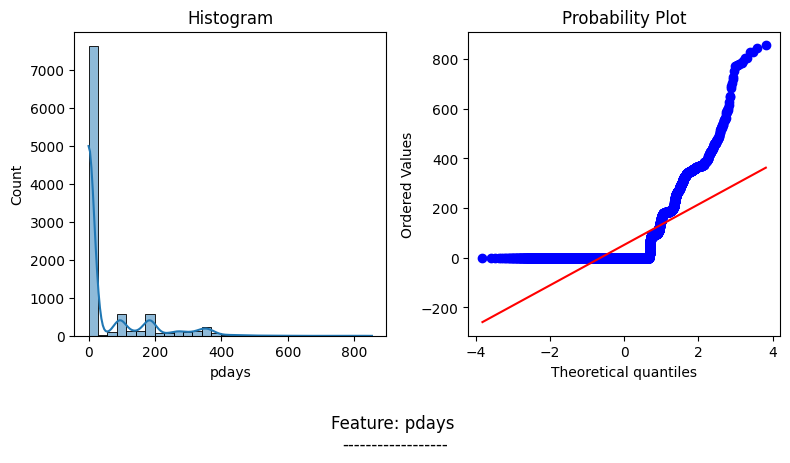

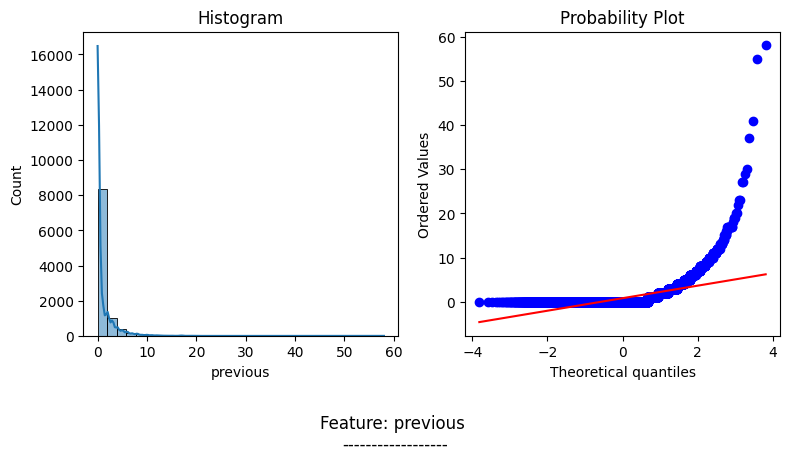

In [16]:
def qq_plot(data, features):
    # display pair plots
    for i in data[features]:
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
        
        sns.histplot(data[i], kde=True, bins=30, ax=ax[0]) # histogram
        ax[0].set_title('Histogram')

        stats.probplot(data[i], plot=ax[1]) # qq plot
        plt.tight_layout() 
        fig.suptitle(f'Feature: {i} \n------------------', y=-0.05)

qq_plot(data, num_features)

In [17]:
fig = make_subplots(rows=2, cols=1, shared_xaxes=True )
    
fig.add_trace(go.Box(x=data['pdays'], name='original'), row=1, col=1)
fig.add_trace(go.Box(x=data[data['pdays'] >0]['pdays'], name='excluding -1 class'), row=2, col=1, )

fig.update_layout(
    title=dict(text="Fig.3 - Days since the last marketing campaign (Pdays) distribution", x=.5, y=0.01, xanchor='center'),
    legend_title_text ='Pdays feature', xaxis2_title_text='Days',
    width=700, height=300,
    margin=dict(l=100, r=60, t=80, b=70))

fig.show()
fig.write_image('../figures/fig_3.png')

In [18]:
fig = make_subplots(rows=2, cols=1, shared_xaxes=True )
    
fig.add_trace(go.Box(x=data['previous'], name='original'), row=1, col=1)
fig.add_trace(go.Box(x=data[data['previous'] >0]['previous'], name='excluding 0 class'), row=2, col=1, )

#fig.update_layout(legend_title_text ='previous feature', xaxis2_title_text='Days')

fig.update_layout(
    title=dict(text="Fig.4 - Number of contacts since the last campaign (previous) distribution", x=.5, y=0.01, xanchor='center'),
    legend_title_text ='Previous feature', 
    xaxis2_title_text='Days',
    width=700, height=300,
    margin=dict(l=100, r=60, t=80, b=70))

fig.show()
fig.write_image('../figures/fig_4.png')


In [19]:
#data['deposit_outcome'] = data['deposit'].apply(lambda x: 1 if x=='yes' else 0)

In [20]:
#data[['previous', 'deposit_outcome']].corr()['deposit_outcome'][0].round(2)

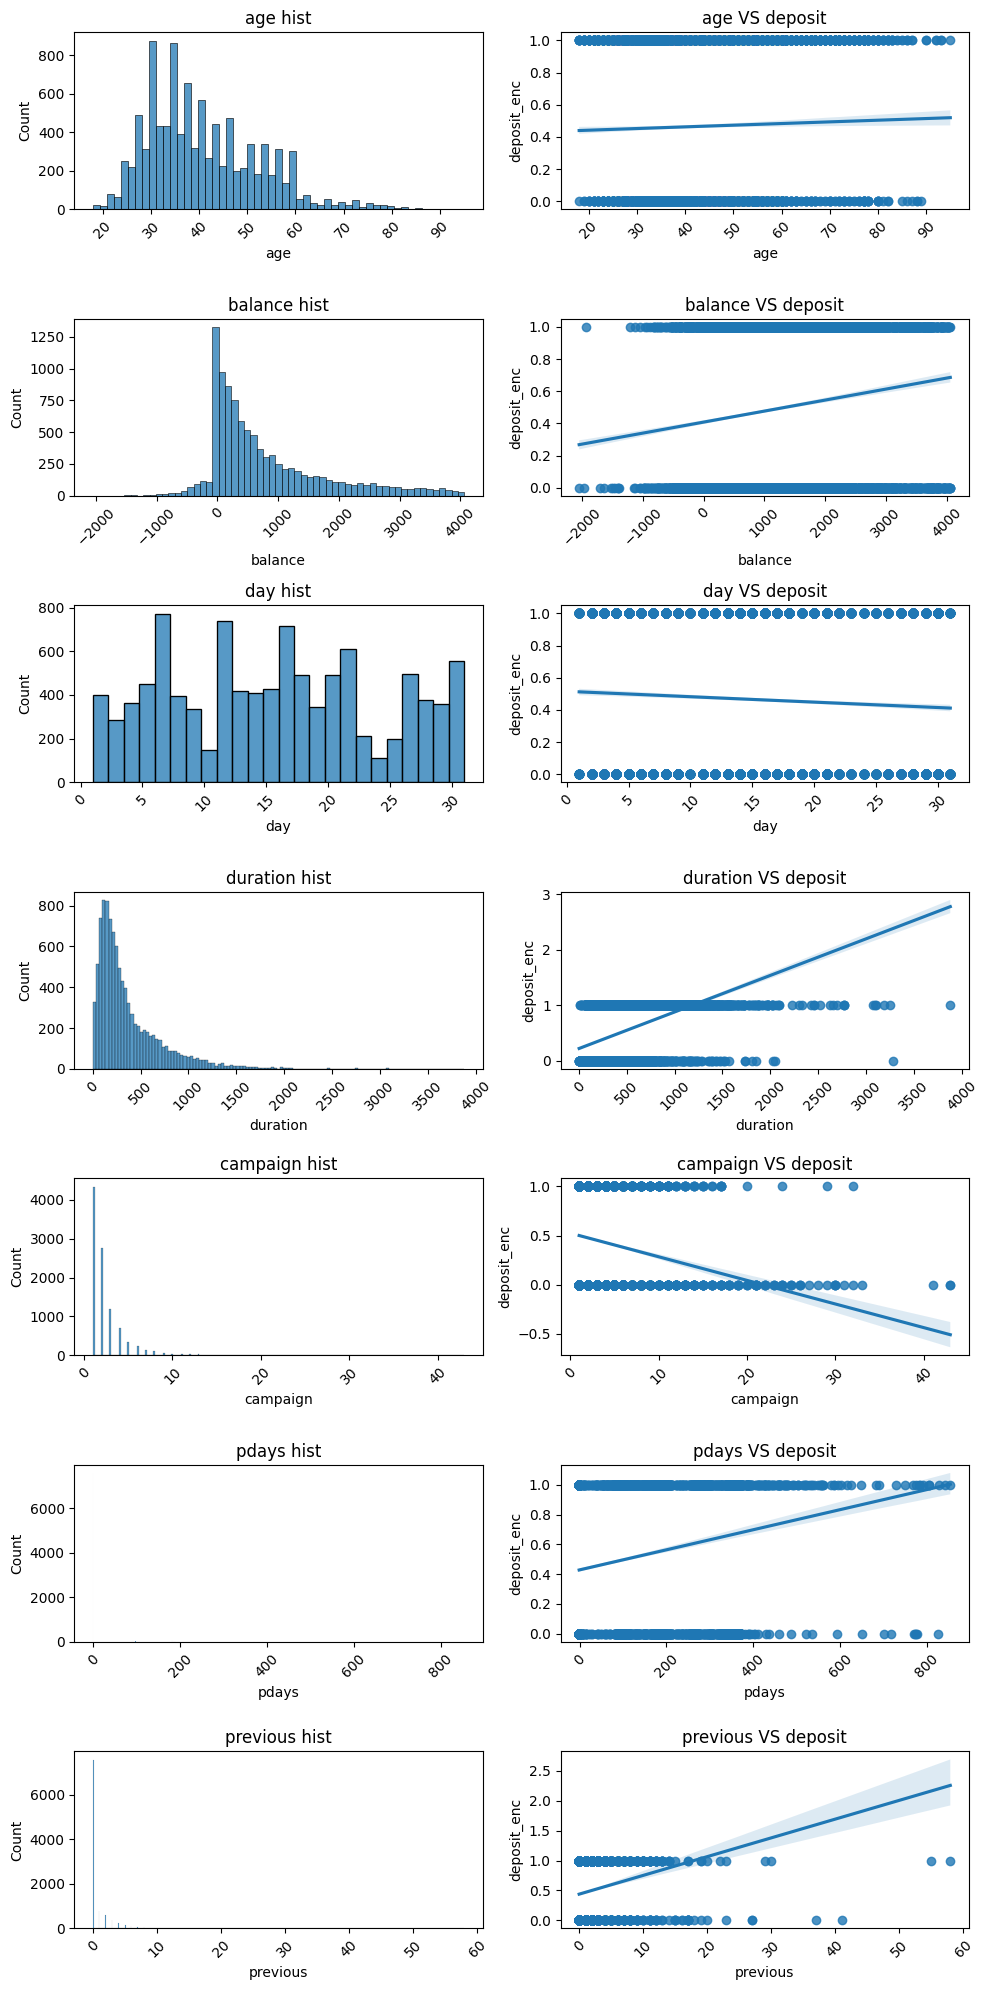

In [21]:
data['deposit_enc'] = data['deposit'].apply(lambda x: 1 if x=='yes' else 0)

n = len(num_features) # numerical features
fig, axes = plt.subplots(n, 2, figsize=(10, 20)) 

# Cycle to study features
for i, feature in enumerate(num_features): #i- index, feature    
    # histogram
    histplot = sns.histplot(data=data, x=feature, ax=axes[i][0])
    histplot.set_title('{} hist'.format(feature))   
    histplot.xaxis.set_tick_params(rotation=45)
    
    # scatter plot with regression
    regplot = sns.regplot(data=data, x=feature, y='deposit_enc', ax=axes[i][1])
    regplot.set_title('{} VS deposit'.format(feature));
    regplot.xaxis.set_tick_params(rotation=45)
           
plt.tight_layout() 

In [22]:
for feature in num_features: #i- index, feature  
    print('Correlation between {} and target is {}'.format(feature, data[[feature, 'deposit_enc']].corr()['deposit_enc'][0].round(2)))

Correlation between age and target is 0.02
Correlation between balance and target is 0.14
Correlation between day and target is -0.06
Correlation between duration and target is 0.46
Correlation between campaign and target is -0.13
Correlation between pdays and target is 0.15
Correlation between previous and target is 0.14


## Category features

In [23]:
# selection of categorical features
cat_features = [s for s in data.columns if data[s].dtypes == 'object']
data[cat_features].describe().T

,count,unique,top,freq
job,10104,11,management,2314
marital,10104,3,married,5714
education,10104,3,secondary,5517
default,10104,2,no,9938
housing,10104,2,no,5243
loan,10104,2,no,8711
contact,10104,3,cellular,7282
month,10104,12,may,2616
poutcome,10104,4,unknown,7570
deposit,10104,2,no,5423


Категориальные признаки: 
* **month** - месяц, в котором состоялся последний контакт. В списке присутствуют  12 разных месяцев. При отсутствии уточняющих данных можно предположить, что маркетинговая кампания длилась год.
* 

### poutcome

In [24]:
data['poutcome'].value_counts()

unknown    7570
failure    1108
success     945
other       481
Name: poutcome, dtype: int64

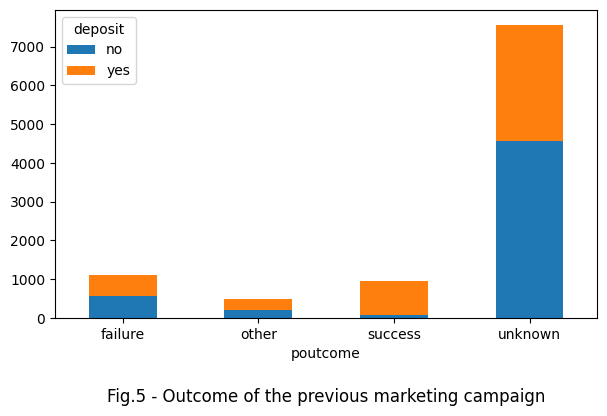

In [25]:
types = data.groupby("poutcome")['deposit'].value_counts(normalize=False).unstack()
fig, ax = plt.subplots(figsize=(7, 4)) 
types.plot(kind='bar', stacked='True', ax=ax)
ax.tick_params(axis='x', rotation=0)
ax.set_title('Fig.5 - Outcome of the previous marketing campaign', y=-0.3);

plt.savefig('../figures/fig_5.png')

#### Poutcome by months

,month,failure,other,success,unknown,ratio
2,dec,11,12,28,42,0.549020
11,sep,46,31,91,110,0.541667
1,aug,84,36,137,1128,0.533074
6,jun,48,28,84,944,0.525000
10,oct,62,20,90,163,0.523256
5,jul,42,26,64,1286,0.484848
7,mar,26,20,42,149,0.477273
3,feb,127,55,93,434,0.338182
4,jan,39,36,37,207,0.330357
9,nov,139,40,85,516,0.321970


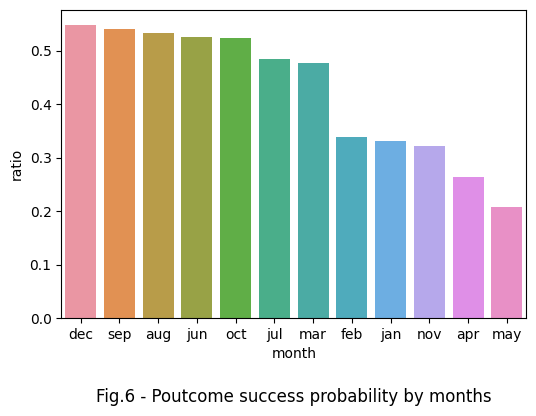

In [26]:
temp=data.groupby(['month','poutcome']).agg('count')[['deposit']].unstack() #

temp.columns = ['failure', 'other','success','unknown']

temp = temp.reset_index()
temp['ratio'] = temp['success']/(temp['failure']+temp['success']+temp['other'])
temp = temp.sort_values(by='ratio', ascending=False)
display(temp)

fig, ax = plt.subplots(figsize=(6, 4)) 
sns.barplot(data=temp, x='month', y="ratio",  ax=ax) #
ax.set_title('Fig.6 - Poutcome success probability by months', y=-0.3);

plt.savefig('../figures/fig_6.png')

### Deposit by age group

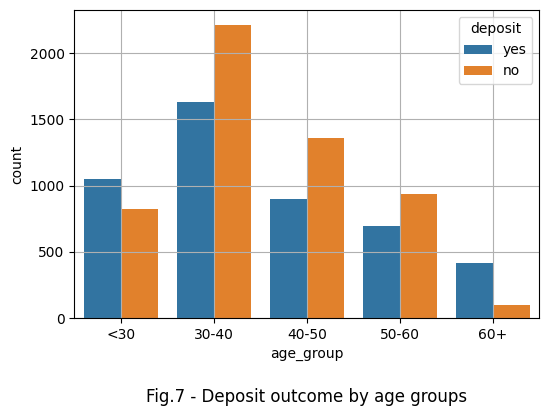

In [27]:
data['age_group'] = pd.cut(df.age, [0,30,40,50,60,9999], labels = ['<30','30-40','40-50','50-60','60+'])
fig, ax = plt.subplots(figsize=(6, 4)) 
sns.countplot(data=data, x="age_group", hue="deposit", ax=ax)
ax.set_title('Fig.7 - Deposit outcome by age groups', y=-0.3)
ax.grid();

plt.savefig('../figures/fig_7.png')

In [28]:
print('Rate of customers deposited money by age groups:')
pivot = data.groupby("age_group")['deposit'].value_counts(normalize=False).unstack().reset_index(names='age_group')
pivot['ratio'] = (pivot['yes']/ (pivot['yes'] + pivot['no'])).round(2)
pivot.sort_values(by='ratio', ascending=False)

Rate of customers deposited money by age groups:


deposit,age_group,no,yes,ratio
4,60+,97,416,0.81
0,<30,819,1051,0.56
3,50-60,933,692,0.43
1,30-40,2215,1627,0.42
2,40-50,1359,895,0.40


### Deposit by marital

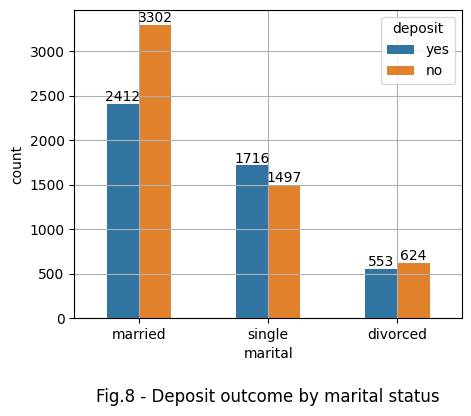

In [29]:
fig, ax = plt.subplots(figsize=(5, 4))
ax = sns.countplot(data=data, x='marital', hue='deposit', width=0.5)
ax.grid();
ax.set_title('Fig.8 - Deposit outcome by marital status', y=-0.3)
for container in ax.containers:
    ax.bar_label(container)
    
plt.savefig('../figures/fig_8.png')

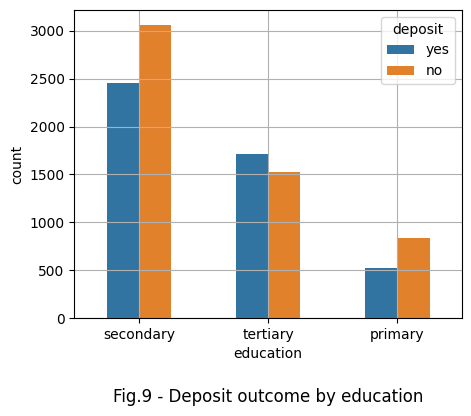

In [30]:
fig, ax = plt.subplots(figsize=(5, 4))
ax = sns.countplot(data=data, x='education', hue='deposit', width=0.5)
ax.grid();
ax.set_title('Fig.9 - Deposit outcome by education', y=-0.3);

plt.savefig('../figures/fig_9.png')

### Deposit by job

In [31]:

fig = px.histogram(data_frame=data, y='job', color='deposit').update_yaxes(categoryorder='total ascending')
fig.update_layout(
    title=dict(text='Fig.10 - Deposit outcome by job', x=.5, y=0.05, xanchor='center'),
    xaxis_title_text = 'job title',
    width=600, height=400,)
fig.show()

fig.write_image('../figures/fig_10.png')

### Deposit by marital and education

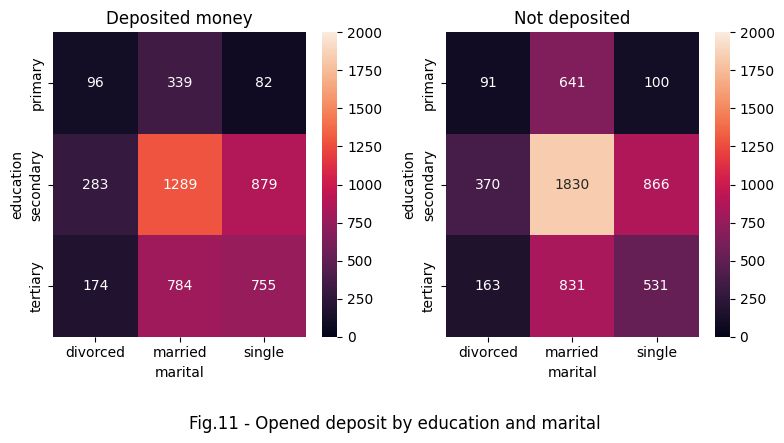

In [32]:
pivot_opened = data[data['deposit']=='yes'].pivot_table(
    values='deposit', 
    index='education', 
    columns='marital', 
    aggfunc='count')

pivot_not_opened = data[data['deposit']=='no'].pivot_table(
    values='deposit', 
    index='education', 
    columns='marital', 
    aggfunc='count')


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

fig = sns.heatmap(pivot_opened, annot=True, fmt=".0f", ax=ax[0], vmin=0, vmax=2000)
fig = sns.heatmap(pivot_not_opened, annot=True, fmt=".0f", ax=ax[1], vmin=0, vmax=2000)

ax[0].set_title('Deposited money')
ax[1].set_title('Not deposited')
plt.tight_layout()
plt.suptitle('Fig.11 - Opened deposit by education and marital', y=-0.05);

plt.savefig('../figures/fig_11.png')

## Feature engineering

### Education

In [33]:
data['education'].value_counts()

secondary    5517
tertiary     3238
primary      1349
Name: education, dtype: int64

In [34]:
# Encoding
le = LabelEncoder()
data['education'] = le.fit_transform(data['education'])
#data['age_group'] = le.fit_transform(data['age_group'])

data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,deposit_enc,age_group
0,59,admin.,married,1,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,1,50-60
1,56,admin.,married,1,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,1,50-60
2,41,technician,married,1,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,1,40-50
3,55,services,married,1,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes,1,50-60
4,54,admin.,married,2,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes,1,50-60


### Encoding categorial features

In [35]:
# delete duplicated feature 'deposit' and restore an original name
data.drop(['deposit'], axis=1, inplace=True)

# delete 'duration'
data.drop(['duration'], axis=1, inplace=True)
data.rename(columns={'deposit_enc':'deposit'}, inplace=True)

In [36]:
# upd categorial features
cat_features = [s for s in data.columns if data[s].dtypes == 'object']

# cycle by categorical features
for i in  cat_features:
    # encoding if a feature contains 2 unique values such as 'yes' and 'no'
    if data[i].nunique() == 2:
        print(i)
        data[i] = data[i].apply(lambda x: 1 if x=='yes' else 0)#.astype(np.int32)
        
data[cat_features].head(1)

default
housing
loan


,job,marital,default,housing,loan,contact,month,poutcome
0,admin.,married,0,1,0,unknown,may,unknown


In [37]:
# Encoding
cat_features = [s for s in data.columns if data[s].dtypes == 'object']

data_encoded = pd.get_dummies(data) #, columns = cat_features
data_encoded.head()

,age,education,default,balance,housing,loan,day,campaign,pdays,previous,...,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,age_group_<30,age_group_30-40,age_group_40-50,age_group_50-60,age_group_60+
0,59,1,0,2343.0,1,0,5,1,-1,0,...,0,0,0,0,1,0,0,0,1,0
1,56,1,0,45.0,0,0,5,1,-1,0,...,0,0,0,0,1,0,0,0,1,0
2,41,1,0,1270.0,1,0,5,1,-1,0,...,0,0,0,0,1,0,0,1,0,0
3,55,1,0,2476.0,1,0,5,1,-1,0,...,0,0,0,0,1,0,0,0,1,0
4,54,2,0,184.0,0,0,5,2,-1,0,...,0,0,0,0,1,0,0,0,1,0


### Check for multicollinearity

In [38]:
# select features with correlation coefficient > 0.7
pivot = data_encoded.corr()

for col in pivot:
    pivot[col] = pivot[col].apply(lambda x: np.nan if (abs(x) < 0.7 or x == 1) else x)
    
for col in pivot:
    pivot = pivot.dropna(how='all')
    pivot = pivot.dropna(how='all', axis='columns')

high_correlation_features = list(pivot.columns) # список признаков c высокой корреляцией
pivot 

print('Features with high correlation coef:')
for count, value in enumerate(high_correlation_features, start=1): # list features from 1
    print(count, value)

Features with high correlation coef:
1 pdays
2 marital_married
3 marital_single
4 contact_cellular
5 contact_unknown
6 poutcome_unknown


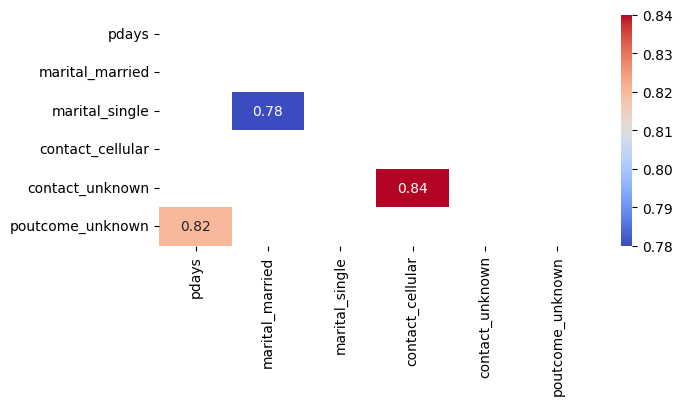

In [39]:
# heatmap
fig = plt.figure(figsize=(7, 3))
matrix = np.triu(pivot)
sns.heatmap(round(abs(pivot), 2), annot=True, cmap= 'coolwarm', mask=matrix);

Since the majority of correlation coefficients are below 0.9, we suppose there is no multicollinearity between features.

In [40]:
#data_encoded = data_encoded.drop(['contact_unknown', 'poutcome_unknown'], axis=1)
#data_encoded.head()

### Normalization

In [41]:
scaler = MinMaxScaler()
#scaler.fit_transform(data_encoded)
X = scaler.fit_transform(data_encoded)
X = pd.DataFrame(X, columns = data_encoded.columns) 
X.head(1)
# X_train = scaler.transform(X_train) 
# X_test = scaler.transform(X_test)

,age,education,default,balance,housing,loan,day,campaign,pdays,previous,...,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,age_group_<30,age_group_30-40,age_group_40-50,age_group_50-60,age_group_60+
0,0.532468,0.5,0.0,0.718704,1.0,0.0,0.133333,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


### Split data

In [42]:
X, y = X.drop(['deposit'], axis=1), X['deposit']

In [43]:
X['balance'] = X['balance'].round(6)
#X['duration'] = X['duration'].round(6)
X['age'] = X['age'].round(6)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state = 42, test_size = 0.33)

print('Test sample:', X_test.shape)

Test sample: (3335, 48)


### Features selection

In [45]:
# 15 Most meaningfull 15 features
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)

features_out_kbest = selector.get_feature_names_out().tolist()
print(features_out_kbest)

# apply selection to X_train and X-test
X_train, X_test = X_train[features_out_kbest], X_test[features_out_kbest]

['balance', 'housing', 'loan', 'campaign', 'pdays', 'previous', 'contact_cellular', 'contact_unknown', 'month_mar', 'month_may', 'month_oct', 'month_sep', 'poutcome_success', 'poutcome_unknown', 'age_group_60+']


In [46]:
# scaler = MinMaxScaler()
# scaler.fit(X_train)                        
# X_train = scaler.transform(X_train) 
# X_test = scaler.transform(X_test)

# Modelling

### Log regression

In [47]:
log_reg = linear_model.LogisticRegression(
    solver='sag', 
    random_state=42, 
    max_iter=1000 )

# train model
log_reg.fit(X_train, y_train) 

# Predict target values
y_pred = log_reg.predict(X_test)

# Metrics report
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.68      0.82      0.74      1790
         1.0       0.73      0.55      0.63      1545

    accuracy                           0.70      3335
   macro avg       0.70      0.69      0.68      3335
weighted avg       0.70      0.70      0.69      3335



### Decision tree

In [48]:
dt = tree.DecisionTreeClassifier(
    criterion='entropy', # criterion
    max_depth=6,  
    #min_samples_leaf = 10, 
    random_state=42 
)
# train model
dt.fit(X_train, y_train)
 
# Predict target values
y_test_pred_dt = dt.predict(X_test)

# Metrics report
print(metrics.classification_report(y_test, y_test_pred_dt))

              precision    recall  f1-score   support

         0.0       0.68      0.74      0.71      1790
         1.0       0.66      0.59      0.63      1545

    accuracy                           0.67      3335
   macro avg       0.67      0.67      0.67      3335
weighted avg       0.67      0.67      0.67      3335



### Optimization using Gridsearch

In [49]:
parameters =  {'min_samples_split': [2, 5, 7, 10], 'max_depth':[3,5,7]}

model_cv = GridSearchCV(tree.DecisionTreeClassifier(random_state=42), 
                        parameters,
                        cv=3, scoring=('f1'), 
                        return_train_score=True)
# search parameters
%time model_cv.fit(X_train, y_train)
 
# Predict target values
y_test_pred_gs = model_cv.predict(X_test)

# Metrics report
print(metrics.classification_report(y_test, y_test_pred_gs))

print("Best parameters: {}".format(model_cv.best_params_))

CPU times: total: 500 ms
Wall time: 512 ms
              precision    recall  f1-score   support

         0.0       0.67      0.64      0.66      1790
         1.0       0.61      0.64      0.62      1545

    accuracy                           0.64      3335
   macro avg       0.64      0.64      0.64      3335
weighted avg       0.64      0.64      0.64      3335

Best parameters: {'max_depth': 3, 'min_samples_split': 2}


### Random forest

In [50]:
rf = ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=42
)

# train model
rf.fit(X_train, y_train)
 
# Predict target values
y_test_pred_rf = rf.predict(X_test)

# Metrics report
print(metrics.classification_report(y_test, y_test_pred_rf))

              precision    recall  f1-score   support

         0.0       0.68      0.83      0.75      1790
         1.0       0.73      0.55      0.63      1545

    accuracy                           0.70      3335
   macro avg       0.71      0.69      0.69      3335
weighted avg       0.71      0.70      0.69      3335



### Gradient boosting

In [51]:
gb = ensemble.GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)

# train model
gb.fit(X_train, y_train)
 
# Predict target values
y_pred_test_gb = gb.predict(X_test)

# Metrics report
print(metrics.classification_report(y_test, y_pred_test_gb))

              precision    recall  f1-score   support

         0.0       0.68      0.80      0.73      1790
         1.0       0.71      0.56      0.63      1545

    accuracy                           0.69      3335
   macro avg       0.69      0.68      0.68      3335
weighted avg       0.69      0.69      0.68      3335



### Stacking

In [52]:
estimators = [
    ('dt', tree.DecisionTreeClassifier(
        criterion='entropy',
        min_samples_leaf=2,
        max_depth=6,
        random_state=random_seed
        )
    ),
    ('dt2', tree.DecisionTreeClassifier(
        criterion='entropy',
        min_samples_leaf=2,
        max_depth=10,
        random_state=random_seed
        )
    ),
    ('log_reg', linear_model.LogisticRegression(
        solver='sag',
        random_state=random_seed
        )
    ),
    ('gb', ensemble.GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=300,
        min_samples_leaf=5,
        max_depth=5,
        random_state=random_seed
        )
    )
]

stack = StackingClassifier(
    estimators,
    final_estimator=linear_model.LogisticRegression(random_state=random_seed)
)
stack.fit(X_train, y_train)

StackingClassifier(estimators=[('dt',
                                DecisionTreeClassifier(criterion='entropy',
                                                       max_depth=6,
                                                       min_samples_leaf=2,
                                                       random_state=42)),
                               ('dt2',
                                DecisionTreeClassifier(criterion='entropy',
                                                       max_depth=10,
                                                       min_samples_leaf=2,
                                                       random_state=42)),
                               ('log_reg',
                                LogisticRegression(random_state=42,
                                                   solver='sag')),
                               ('gb',
                                GradientBoostingClassifier(learning_rate=0.05,
                                                           max_depth=5,
                                                           min_samples_leaf=5,
                                                           n_estimators=300,
                                                           random_state=42))],
                   final_estimator=LogisticRegression(random_state=42))

In [53]:
# Predict target values
y_test_pred_st = stack.predict(X_test)

# Metrics report
print(metrics.classification_report(y_test, y_test_pred_st))

              precision    recall  f1-score   support

         0.0       0.69      0.78      0.73      1790
         1.0       0.70      0.59      0.64      1545

    accuracy                           0.69      3335
   macro avg       0.69      0.69      0.69      3335
weighted avg       0.69      0.69      0.69      3335



In [54]:
rf_score = metrics.f1_score(y_test, y_test_pred_rf).round(4)
gb_score = metrics.f1_score(y_test, y_pred_test_gb).round(4)
st_score = metrics.f1_score(y_test, y_test_pred_st).round(4)

mod_f1_scores = np.array([rf_score, st_score, gb_score])
mod_names = np.argmax(np.array([rf_score, st_score, gb_score]))
mod_best = ['rf model is better','st model is better', 'gb model is better']
print(mod_best[mod_names],'F1 score is: ',mod_f1_scores[mod_names])


st model is better F1 score is:  0.6397


Most important features

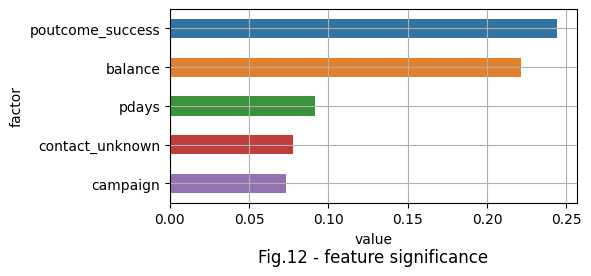

In [55]:
# arrays names and values
f_keys, f_values = np.array(X_train.columns), gb.feature_importances_
# sort and reverse arrays
idx   = np.argsort(f_values)[::-1]

f_keys, f_values = np.array(f_keys)[idx], np.array(f_values)[idx]

# Table
f_keys, f_values = np.array(f_keys)[idx], np.array(f_values)[idx]

factors = pd.DataFrame({'factor':f_keys,
              'value':f_values
}).sort_values(by='value', ascending=False).head(5)

# display a bar chart
fig, ax = plt.subplots(figsize=(6, 3))
sns.barplot(factors, x='value', y='factor', width=0.5)
ax.grid()
ax.set_title('Fig.12 - feature significance', y=-0.35); 
plt.tight_layout()

plt.savefig('../figures/fig_12.png')

### Optimization with Optuna

In [56]:
def optuna_rf(trial):
    # set dimensions
    n_estimators = trial.suggest_int('n_estimators', 100, 300, 1)
    max_depth = trial.suggest_int('max_depth', 8, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
    criterion = trial.suggest_categorical('criterion', ["gini", "entropy", "log_loss"])
    
    # model creation 
    model = ensemble.RandomForestClassifier(
      n_estimators=n_estimators,
      max_depth=max_depth,
      min_samples_leaf=min_samples_leaf,
      criterion=criterion,
      random_state=random_seed)
    
    # training
    model.fit(X_train, y_train)
    score = metrics.f1_score(y_train, model.predict(X_train))

    return score 

In [57]:
%%time
# create study set
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# try multiple times
study.optimize(optuna_rf, n_trials=20)

[I 2023-02-27 00:31:12,648] A new study created in memory with name: RandomForestClassifier
[I 2023-02-27 00:31:14,032] Trial 0 finished with value: 0.6585365853658537 and parameters: {'n_estimators': 259, 'max_depth': 17, 'min_samples_leaf': 10, 'criterion': 'entropy'}. Best is trial 0 with value: 0.6585365853658537.
[I 2023-02-27 00:31:15,424] Trial 1 finished with value: 0.7169811320754716 and parameters: {'n_estimators': 229, 'max_depth': 20, 'min_samples_leaf': 4, 'criterion': 'log_loss'}. Best is trial 1 with value: 0.7169811320754716.
[I 2023-02-27 00:31:15,985] Trial 2 finished with value: 0.6832753251511265 and parameters: {'n_estimators': 100, 'max_depth': 20, 'min_samples_leaf': 7, 'criterion': 'entropy'}. Best is trial 1 with value: 0.7169811320754716.
[I 2023-02-27 00:31:17,057] Trial 3 finished with value: 0.6847345132743363 and parameters: {'n_estimators': 179, 'max_depth': 13, 'min_samples_leaf': 2, 'criterion': 'entropy'}. Best is trial 1 with value: 0.7169811320754716

CPU times: total: 23.7 s
Wall time: 23.8 s


#### Display optimization results

In [58]:
# Display results
print("Best hyperparameters {}".format(study.best_params))

Best hyperparameters {'n_estimators': 198, 'max_depth': 30, 'min_samples_leaf': 2, 'criterion': 'gini'}


In [59]:
fig = optuna.visualization.plot_optimization_history(study, target_name="f1_score")

fig.write_image('../figures/fig_13.png')

<center> <img src="../figures/fig_13.png"></center>

In [60]:
optuna.visualization.plot_param_importances(study, target_name="f1_score")

In [61]:
# Apply best parameters
model_rf_opt = ensemble.RandomForestClassifier(**study.best_params,random_state=random_seed)
model_rf_opt.fit(X_train, y_train)

RandomForestClassifier(max_depth=30, min_samples_leaf=2, n_estimators=198,
                       random_state=42)

### Save model

In [62]:
# Save model to the given path in the pkl format
model_path = '../models/'
full_path = os.path.join(model_path, 'model_rf_opt.pkl') #'.pkl'

with open(full_path, 'wb') as f:
    pickle.dump(model_rf_opt, f)

In [63]:
# recover saved model
with open(full_path, 'rb') as f:
    model_rf_opt = pickle.load(f)

In [64]:
y_test_pred_rf_opt = model_rf_opt.predict(X_test)
y_test_pred_rf_opt_prob = model_rf_opt.predict_proba(X_test)
# Metrics report
print(metrics.classification_report(y_test, y_test_pred_rf_opt))

              precision    recall  f1-score   support

         0.0       0.67      0.75      0.71      1790
         1.0       0.66      0.58      0.62      1545

    accuracy                           0.67      3335
   macro avg       0.67      0.66      0.66      3335
weighted avg       0.67      0.67      0.67      3335



In [65]:
# Comparison
#rf_score = metrics.f1_score(y_test, y_test_pred_rf).round(4)
#gb_score = metrics.f1_score(y_test, y_pred_test_gb).round(4)
#st_score = metrics.f1_score(y_test, y_test_pred_st).round(4)
rf_opt_score = metrics.f1_score(y_test, y_test_pred_rf_opt).round(4)

mod_f1_scores = np.array([rf_score, st_score, gb_score, rf_opt_score])
mod_names = np.argmax(np.array([rf_score, st_score, gb_score, rf_opt_score]))
mod_best = ['rf model is better','st model is better', 'gb model is better', 'rf optimized model is better']
print(mod_best[mod_names],'. F1 score is: ', mod_f1_scores[mod_names])

st model is better . F1 score is:  0.6397


## Model study

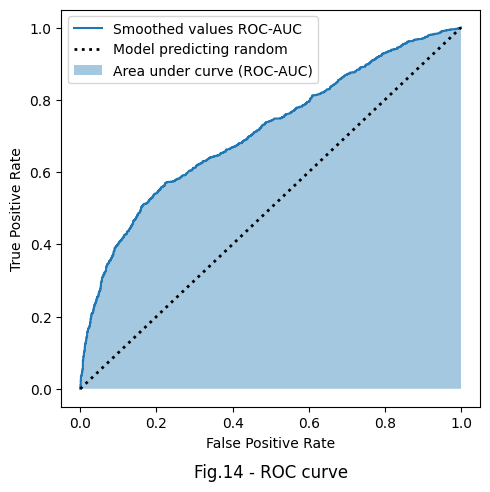

In [66]:
false_positive_rates, true_positive_rates, threshold = roc_curve(y_test, y_test_pred_rf_opt_prob[:, 1])


# Plot
fig, ax = plt.subplots(figsize=(5, 5))

# ROC curve
ax.plot(false_positive_rates, true_positive_rates, 
         label='Smoothed values ROC-AUC')

# Random model
ax.plot([0, 1], [0, 1], color='k', lw=2, linestyle=':', 
         label='Model predicting random ')

ax.set_title('Fig.14 - ROC curve', y=-0.2)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

ax.fill_between(false_positive_rates, 
                true_positive_rates, 
                step="pre", 
                alpha=0.4, label='Area under curve (ROC-AUC)')
ax.legend();
plt.tight_layout();

plt.savefig('../figures/fig_14.png');